# Calories prediction from factors [Gender, Age, Height, Weight, Duration, Heart rate]
#### Dataset - https://www.kaggle.com/fmendes/fmendesdat263xdemos

#### Step 1: Build a model to predict calories and test using test data
#### Step 2: Use apple watch data and predict the calories

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics

import xmltodict

In [2]:
calories_data = pd.read_csv("data/calories.csv")
exercise_data = pd.read_csv("data/exercise.csv")
exercise_data = exercise_data.drop(columns = 'Body_Temp')

In [3]:
calories_data.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [4]:
exercise_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate
0,14733363,male,68,190.0,94.0,29.0,105.0
1,14861698,female,20,166.0,60.0,14.0,94.0
2,11179863,male,69,179.0,79.0,5.0,88.0
3,16180408,female,34,179.0,71.0,13.0,100.0
4,17771927,female,27,154.0,58.0,10.0,81.0


#### Dataset and Analysis

In [5]:
data = pd.concat([exercise_data, calories_data['Calories']], axis=1)
data.shape

(15000, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 937.6+ KB


In [7]:
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,35.0


<AxesSubplot:>

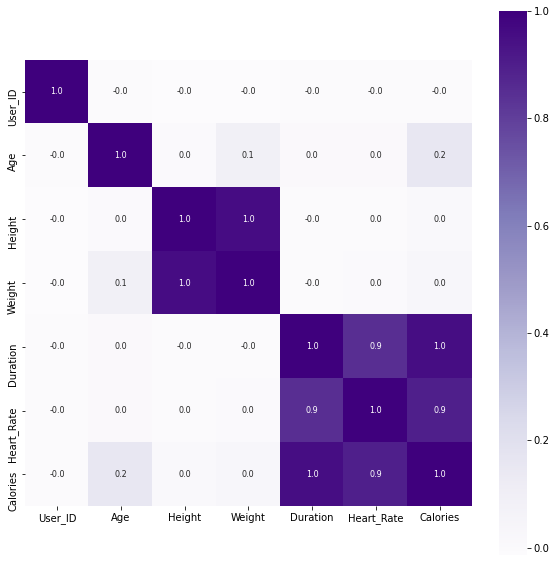

In [8]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Purples')

In [9]:
data.replace({'Gender':{'male':0,'female':1}},inplace=True)
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,35.0


In [10]:
X = data.drop(['User_ID','Calories'],axis=1)
Y = data['Calories']

## Model

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)
print('X:' + str(X.shape) + '\nX_train:' + str(X_train.shape) + '\nX_test' + str(X_test.shape))

X:(15000, 6)
X_train:(12000, 6)
X_test(3000, 6)


### XGBoost Regressor

In [12]:
xg_model = XGBRegressor()
xg_model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Test score

In [13]:
test_pred = xg_model.predict(X_test)
mae = metrics.mean_absolute_error(Y_test, test_pred)
print("Mean Absolute Error = ",mae)

Mean Absolute Error =  1.4466921161611874


## Predict for data from Apple Health

### Import Apple Health data

In [14]:
input_path = 'Wearables_data/apple_health_export/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())
    
# Records list for general health data & imported as Pandas Data Frame
records_list = input_data['HealthData']['Record']
df_records = pd.DataFrame(records_list)

### Extract data

In [15]:
# Extract records with heart rate values
heartrate_records = df_records[df_records['@unit']=='count/min']

# Calculate duration from start and end time
heartrate_records['Duration'] = pd.to_datetime(heartrate_records['@endDate']) - pd.to_datetime(heartrate_records['@startDate'])
heartrate_records['Duration'] = pd.to_timedelta(heartrate_records['Duration']).astype('timedelta64[m]').astype(int)

<ipython-input-15-b519b0ad6c13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heartrate_records['Duration'] = pd.to_datetime(heartrate_records['@endDate']) - pd.to_datetime(heartrate_records['@startDate'])
<ipython-input-15-b519b0ad6c13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heartrate_records['Duration'] = pd.to_timedelta(heartrate_records['Duration']).astype('timedelta64[m]').astype(int)


In [16]:
# Extract the necessary features
test_data = heartrate_records[['Duration', '@value']]
test_data = test_data.rename(columns= {'@value':'Heart_Rate'})

In [17]:
# Add personal data values
test_data['Gender'] = 'female'
test_data['Age'] = 25
test_data['Height'] = 160
test_data['Weight'] = 54

# Final processing
test_data = test_data[['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate']]
test_data.replace({'Gender':{'male':0,'female':1}},inplace=True)
test_data.head()

# Change datatypes
test_data = test_data.astype({'Height':'float64','Weight':'float64','Duration':'float64','Heart_Rate':'float64'})

# Extract necessary data samples

# Remove samples with 0 minutes duration or less than 60 seconds and more than 60 minutes
test_data = test_data[(test_data.Duration != 0) & (test_data.Duration < 60)].reset_index(drop = True)

# Heart rate must be between 122 and 200 bpm
test_data = test_data[(test_data.Heart_Rate > 122) & (test_data.Heart_Rate < 200)]

print('Number of samples from Apple watch : ', test_data.shape[0])

Number of samples from Apple watch :  34


In [18]:
test_data.dtypes

Gender          int64
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
dtype: object

### Predict calories for data from Apple watch

In [56]:
prediction = xg_model.predict(test_data)

#### Samples and predictions
Verify : http://www.shapesense.com/fitness-exercise/calculators/heart-rate-based-calorie-burn-calculator.shtml

In [57]:
apple_data_pred = test_data.copy()
apple_data_pred['Predicted calories'] = prediction

In [58]:
apple_data_pred

,Gender,Age,Height,Weight,Duration,Heart_Rate,Predicted calories
0,1,25,160.0,54.0,17.0,135.898,119.739189
2,1,25,160.0,54.0,15.0,153.854,105.207886
3,1,25,160.0,54.0,9.0,166.268,67.549301
4,1,25,160.0,54.0,16.0,149.771,115.224678
5,1,25,160.0,54.0,16.0,154.715,115.224678
6,1,25,160.0,54.0,13.0,147.043,92.979454
7,1,25,160.0,54.0,7.0,143.595,55.623108
8,1,25,160.0,54.0,11.0,138.650,78.857788
9,1,25,160.0,54.0,8.0,148.303,62.214874
10,1,25,160.0,54.0,16.0,138.151,115.224678


## Save model

In [59]:
import pickle

In [60]:
pickle.dump(xg_model, open("prediction_model.pkl", "wb"))

## Predict from saved model

In [61]:
loaded_model = pickle.load(open("prediction_model.pkl", "rb"))
result = loaded_model.predict(test_data)
print(result)

[119.73919  105.207886  67.5493   115.22468  115.22468   92.979454
  55.623108  78.85779   62.214874 115.22468   78.85779   31.261847
  85.58874   44.82109  243.82677  131.81444  243.82677  225.59875
  99.13237  243.82677  188.78203  243.82677  243.82677  243.82677
  35.80267   99.13237  243.82677  243.82677  243.82677  243.82677
 205.00029  131.81444  243.82677  243.82677 ]


In [ ]:
# import requests
# url = 'https://127.0.0.1:5000'
# pred = requests.post(url,json={'age':55, 'sex':'male', 'bmi':59, 'children':1, 'smoker':'male', 'region':'northwest'})
# print(pred.json())